In [1]:
import pathlib, sys; sys.path.append(str(pathlib.Path(sys.path[0]).parent / "libs"))

In [2]:
import math

from tqdm import tqdm
import numpy as np
import sympy as sp
import qutip
import matplotlib.pyplot as plt
from IPython.display import display, Math


def print_math(expr):
    display(Math(expr))

In [3]:
%reload_ext autoreload
%autoreload 2

import bec

In [4]:
n_bosons = 3
phase = 0 # np.pi / 4
# model = BEC_Qubits.init_alexey2003(n_bosons=n_bosons, phase=phase)
model = bec.BEC_Qubits.init_default(n_bosons=n_bosons, phase=phase)
print(model)
print_math(f"G = {model.G:.3e}" + "\mbox{ (Coupling strength)}")
print_math(r"\Delta = " + f"{model.delta:.3e}")
print_math(r"\frac{G^2}{\Delta} = " + f"{model.G**2 / model.delta:.0e}")
print_math(r"\frac \Delta G = " + f"{model.delta / model.G :.0e}" + " \gg 1")
print_math(r"\Omega = " + f"{model.Omega}")

BEC_Qubits(n_bosons=3, coupling_strength=1, transition_ampl=1, transition_freq=11, resonance_freq=1, phase=0)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [5]:
tspan, dt = np.linspace(0, 2 / model.Omega, 5001, retstep=True)

## Эволюция под действием гамильтониана $H^\mathrm{tot}_\mathrm{eff}$

In [6]:
h_eff_tot = bec.h_eff_total(model) # здесь оmega это константа зеемановской части, а d перед zz

omega = -2.725e-01; d = 5.000e-04


In [7]:
init_state = (
    bec.coherent_state_constructor(model, 0) 
    * bec.coherent_state_constructor(model, 1, math.sqrt(1/10), math.sqrt(9/10)) 
    * bec.vacuum_state(model)
)

In [8]:
result = qutip.mesolve(h_eff_tot, init_state, tspan, [], [], progress_bar=True)
states_under_h_eff_tot = list(result.states)

10.0%. Run time:   0.12s. Est. time left: 00:00:00:01
20.0%. Run time:   0.22s. Est. time left: 00:00:00:00
30.0%. Run time:   0.32s. Est. time left: 00:00:00:00
40.0%. Run time:   0.42s. Est. time left: 00:00:00:00
50.0%. Run time:   0.52s. Est. time left: 00:00:00:00
60.0%. Run time:   0.62s. Est. time left: 00:00:00:00
70.0%. Run time:   0.72s. Est. time left: 00:00:00:00
80.0%. Run time:   0.82s. Est. time left: 00:00:00:00
90.0%. Run time:   0.92s. Est. time left: 00:00:00:00
Total run time:   1.02s


### Фиделити состояния всей системы

In [9]:
fidelity_span = [qutip.metrics.fidelity(init_state, s) for s in tqdm(states_under_h_eff_tot, ncols=80)]

100%|████████████████████████████████████| 5001/5001 [00:00<00:00, 98648.89it/s]


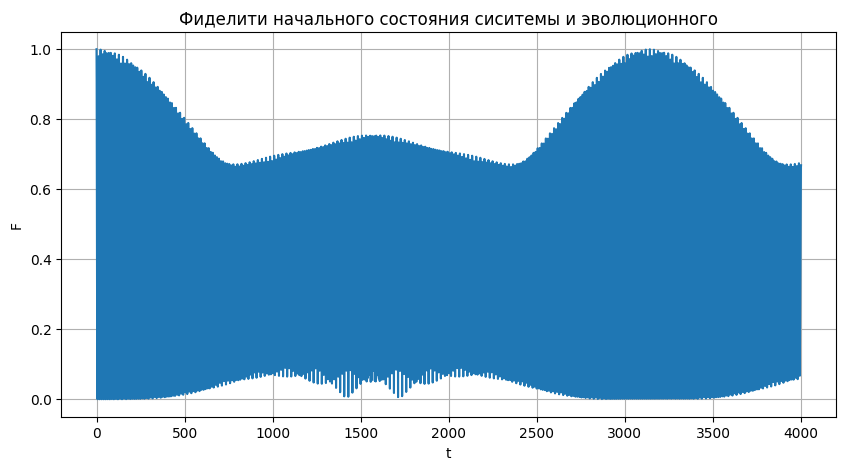

In [10]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan, fidelity_span)
ax.set_ylabel("F")
ax.set_xlabel("t")
ax.set_title("Фиделити начального состояния сиситемы и эволюционного")
ax.grid()

### Фиделити между кубитами

Фиделити в начальный момент времени

In [11]:
qutip.metrics.fidelity(qutip.ptrace(init_state * init_state.dag(), [0, 1]), qutip.ptrace(init_state * init_state.dag(), [2, 3]))

0.7155417527999326

Фиделети между эволюционными состояниями кубитов

In [12]:
fidelity_span12 = [np.round(qutip.metrics.fidelity(qutip.ptrace(s * s.dag(), [0, 1]), qutip.ptrace(s * s.dag(), [2, 3])), 7) for s in tqdm(states_under_h_eff_tot, ncols=80)]

100%|██████████████████████████████████████| 5001/5001 [00:05<00:00, 943.17it/s]


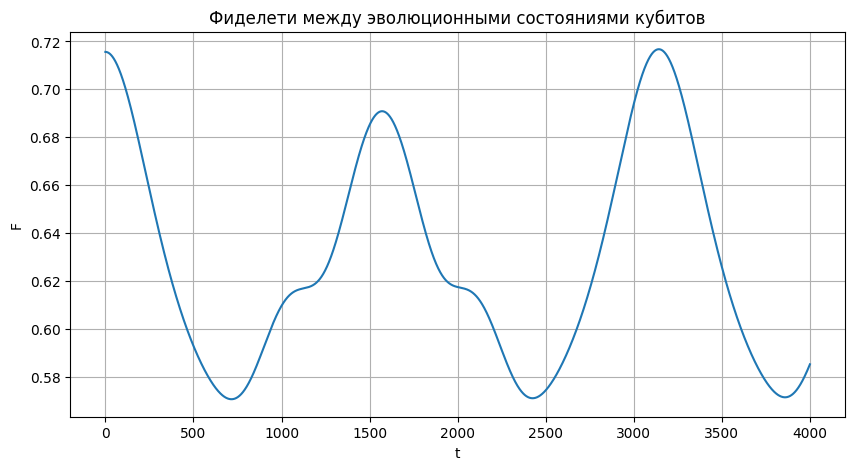

In [13]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan, fidelity_span12)
ax.set_ylabel("F")
ax.set_xlabel("t")
ax.set_title("Фиделети между эволюционными состояниями кубитов")
ax.grid()

### Фиделити состояний первого и второго кубита по отношению к начальному состоянию

In [14]:
init_rho1 = qutip.ptrace(init_state, [2, 3])
init_rho2 = qutip.ptrace(init_state, [0, 1])
fidelity_span1 = [np.round(qutip.metrics.fidelity(init_rho1, qutip.ptrace(s * s.dag(), [2, 3])), 7) for s in tqdm(states_under_h_eff_tot, ncols=80)]
fidelity_span2 = [np.round(qutip.metrics.fidelity(init_rho2, qutip.ptrace(s * s.dag(), [0, 1])), 7) for s in tqdm(states_under_h_eff_tot, ncols=80)]

100%|██████████████████████████████████████| 5001/5001 [00:05<00:00, 919.92it/s]


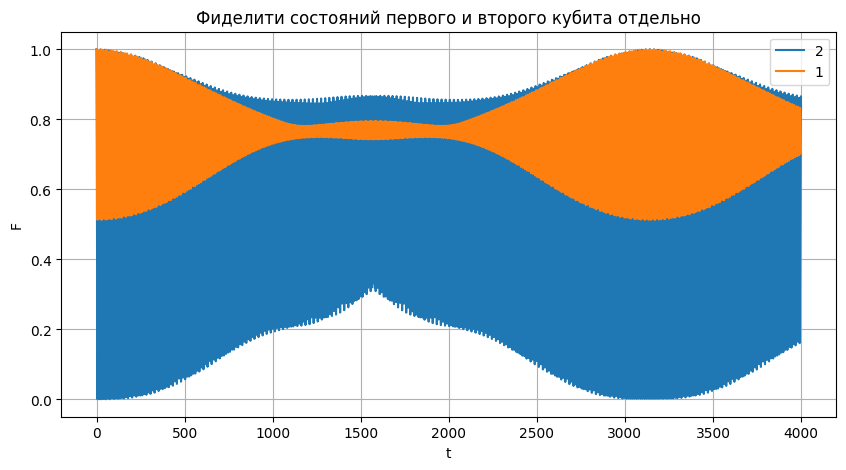

In [15]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan, fidelity_span2, '-', label="2")
ax.plot(tspan, fidelity_span1, '-', label="1")
ax.set_xlabel("t")
ax.set_ylabel("F")
ax.set_title("Фиделити состояний первого и второго кубита отдельно")
ax.legend()
ax.grid()

### Среднее значене $S_z$

In [16]:
e_opts = [bec.sz(model, 0) + bec.sz(model, 1)]
r = qutip.mesolve(h_eff_tot, init_state, tspan, [], e_opts)

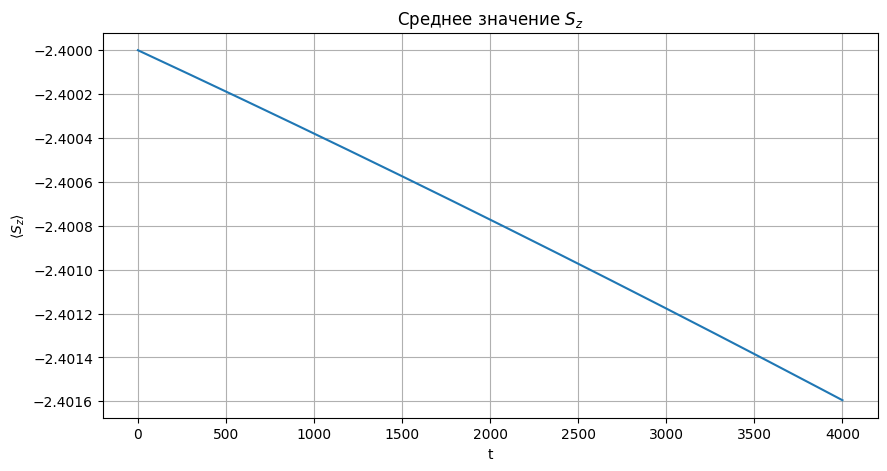

In [17]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan, r.expect[0], "-")
ax.set_ylabel(r"$\langle S_z \rangle$")
ax.set_xlabel("t")
ax.set_title("Среднее значение $S_z$")
ax.grid()

## Среднее значене Sz

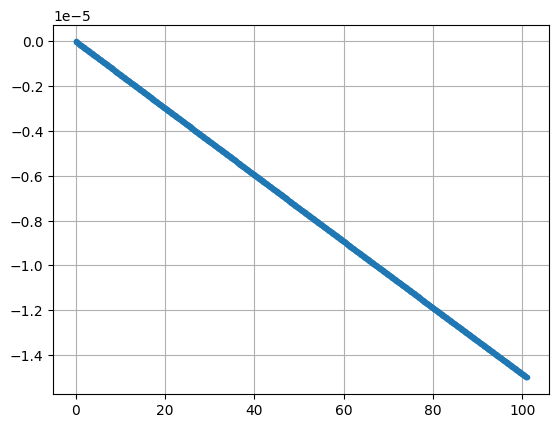

In [10]:
e_opts = [bec.sz(model, 0) + bec.sz(model, 1)]
r = qutip.mesolve(h, init_state, tspan, [], e_opts)
plt.plot(tspan, r.expect[0], ".-")
plt.grid()